In [4]:
from keras.preprocessing import image
from keras.models import load_model
from keras.applications.vgg16 import preprocess_input
import numpy as np
model=load_model('final_model.h5') #Loading our model

In [13]:
import glob
import random

# Get all image files
image_paths = glob.glob('./data/images/*.png')  # or *.jpg, *.jpeg, etc.

# Random sample - single image
random_image = random.choice(image_paths)

# Random sample - multiple images
random_images = random.sample(image_paths, k=5)  # sample 5 images

In [28]:
img_path = "./data/images/00000056_000.png"

In [29]:
img = image.load_img(img_path,target_size=(224,224))
imagee=image.img_to_array(img) #Converting the X-Ray into pixels
imagee=np.expand_dims(imagee, axis=0)
img_data=preprocess_input(imagee)
prediction=model.predict(img_data)
print(prediction[0])
if prediction[0][0]<prediction[0][1]: #Printing the prediction of model.
	print('Person is safe.')
else:
	print('Person is affected with Pneumonia.')
print(f'Predictions: {prediction}')

# This code is modified by Susobhan Akhuli

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
[0.9685329  0.03146709]
Person is affected with Pneumonia.
Predictions: [[0.9685329  0.03146709]]


In [30]:
import cv2

img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))

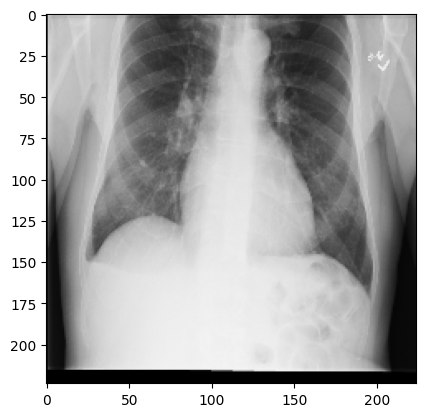

In [31]:
import matplotlib.pyplot as plt

plt.imshow(img)
plt.show()

In [36]:
last_conv_layer_name = "block5_conv3"  # shape (28,28,512)

In [38]:
import tensorflow as tf

flatten_output = model.get_layer('flatten_2').output
logits_layer = tf.keras.layers.Dense(2, activation=None, name='logits')
logits = logits_layer(flatten_output)

In [39]:
from tensorflow.keras import Model, Input

grad_model = Model(
    inputs=model.input,
    outputs=[model.get_layer(last_conv_layer_name).output, logits]
)



--- FORWARD PASS ---
conv_outputs: shape=(1, 14, 14, 512), min=0.00000, max=118.79177, nan=False, inf=False
predictions: shape=(1, 2), min=-0.47661, max=0.90343, nan=False, inf=False
Conv outputs shape: (14, 14, 512)
selected class_index: 1
class_channel: shape=(1,), min=0.90343, max=0.90343, nan=False, inf=False

--- BACKWARD PASS ---
Gradients flowing? min=-0.015463470481336117, max=0.015463348478078842
grads: shape=(1, 14, 14, 512), min=-0.01546, max=0.01546, nan=False, inf=False
pooled_grads: shape=(512,), min=-0.00119, max=0.00089, nan=False, inf=False
conv_outputs[0]: shape=(14, 14, 512), min=0.00000, max=118.79177, nan=False, inf=False
raw heatmap: shape=(14, 14), min=-0.06324, max=0.08956, nan=False, inf=False
relu heatmap: shape=(14, 14), min=0.00000, max=0.08956, nan=False, inf=False
heatmap max: shape=(), min=0.08956, max=0.08956, nan=False, inf=False
normalized heatmap: shape=(14, 14), min=0.00000, max=1.00000, nan=False, inf=False


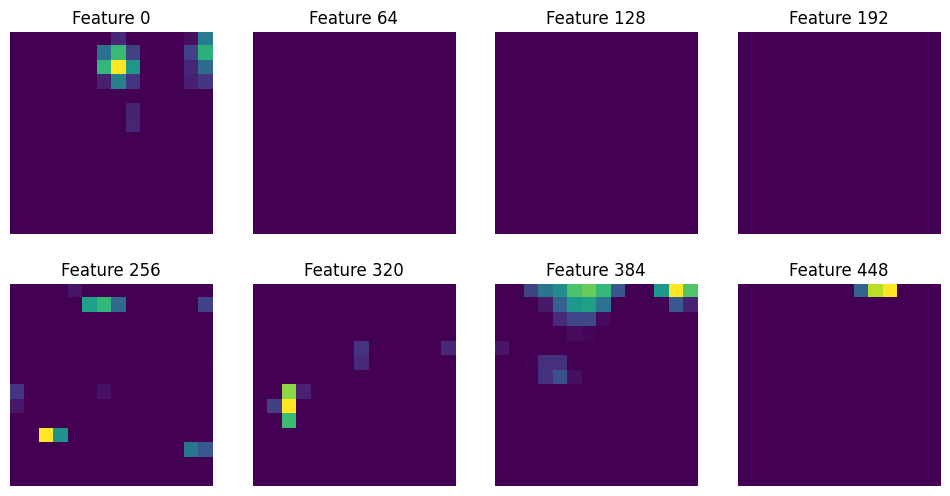

In [44]:
heatmap = make_gradcam_heatmap(img_data, model, grad_model)


In [45]:
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))

heatmap_resized = cv2.resize(heatmap, (224, 224))
heatmap_uint8 = np.uint8(255 * heatmap_resized)
heatmap_colored = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
overlay = cv2.addWeighted(img, 0.6, heatmap_colored, 0.4, 0)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

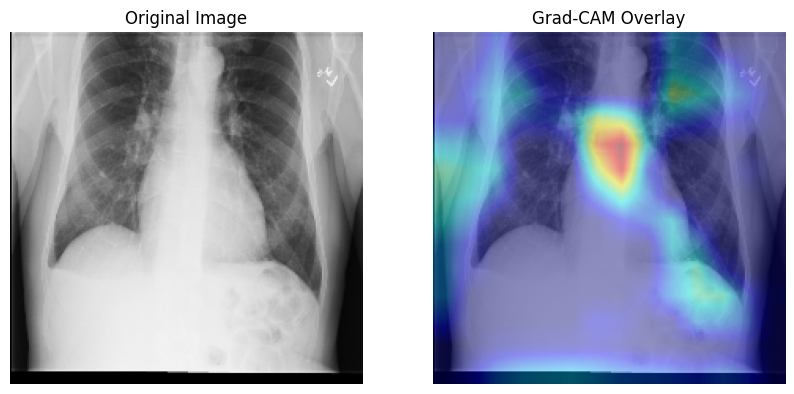

In [46]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(overlay_rgb)
plt.title("Grad-CAM Overlay")
plt.axis("off")

plt.show()

# Functions

In [34]:
def check_tensor(name, t):
    if t is None:
        print(f"{name}: NONE")
        return

    t_np = t.numpy() if hasattr(t, "numpy") else t
    print(
        f"{name}: "
        f"shape={t_np.shape}, "
        f"min={t_np.min():.5f}, "
        f"max={t_np.max():.5f}, "
        f"nan={np.isnan(t_np).any()}, "
        f"inf={np.isinf(t_np).any()}"
    )


In [43]:
def make_gradcam_heatmap(img_array, model, grad_model, class_index=None):
    print("\n--- FORWARD PASS ---")
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        check_tensor("conv_outputs", conv_outputs)
        check_tensor("predictions", predictions)
        # Right after getting conv_outputs in your gradcam function:
        conv_outputs_np = conv_outputs[0].numpy()
        print(f"Conv outputs shape: {conv_outputs_np.shape}")
        
        # Visualize a few feature maps
        fig, axes = plt.subplots(2, 4, figsize=(12, 6))
        for i in range(8):
            ax = axes[i//4, i%4]
            ax.imshow(conv_outputs_np[:, :, i*64], cmap='viridis')
            ax.set_title(f'Feature {i*64}')
            ax.axis('off')
        plt.savefig('feature_maps.png')
        
        if class_index is None:
            class_index = tf.argmax(predictions[0])
            print("selected class_index:", int(class_index))

        class_channel = predictions[:, class_index]
        check_tensor("class_channel", class_channel)

    print("\n--- BACKWARD PASS ---")

    grads = tape.gradient(class_channel, conv_outputs)
    # After fixing the gradient issue, print this:
    print(f"Gradients flowing? min={grads.numpy().min()}, max={grads.numpy().max()}")

    # Visualize multiple samples from BOTH classes
    # Does class 0 highlight lungs but class 1 highlights axilla?
    check_tensor("grads", grads)
    if grads is None:
        raise RuntimeError("Gradients are None. Wrong layer or no gradient flow.")

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    check_tensor("pooled_grads", pooled_grads)

    conv_outputs = conv_outputs[0]
    check_tensor("conv_outputs[0]", conv_outputs)

    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)
    check_tensor("raw heatmap", heatmap)
    
    heatmap = tf.maximum(heatmap, 0)
    check_tensor("relu heatmap", heatmap)

    max_val = tf.reduce_max(heatmap)
    check_tensor("heatmap max", max_val)

    heatmap = tf.where(
        max_val > 0,
        heatmap / max_val,
        tf.zeros_like(heatmap)
    )
    check_tensor("normalized heatmap", heatmap)

    return heatmap.numpy()